In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# LIBRARIES:

In [ ]:
import numpy as np
import pandas as pd
from progressbar import ProgressBar

from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-whitegrid')

import tensorflow as tf
from tensorflow import keras as keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

# PATHS:

In [ ]:
data_path = 'gdrive/My Drive/1_PROJECTS/2_APPAREL_RECOMMENDATION/DATA/'
img_path = data_path + '16k_images/'

# DATA:

In [ ]:
arryO_valid_idxs = np.load(data_path + 'arryO_valid_idxs.npy')

In [ ]:
df_full = pd.read_csv(data_path + 'df_text_vectorize.csv')
df_full.head()

,img,text
0,B016I2TS4W.jpeg,women superheroes for ironman round neck sleev...
1,B01N49AI08.jpeg,fig womens izo clothing shirt tunic
2,B01JDPCOHO.jpeg,fig top womens clothing won shirt
3,B01N19U5H5.jpeg,sailor women girl top collar harajuku focal18 ...
4,B004GSI2OS.jpeg,stone onyx black featherlite twill resistant s...


In [ ]:
df_imgs = df_full.iloc[arryO_valid_idxs]
df_imgs.shape

(11879, 2)

# FN FOR VGG16 VECTORIZATION:

In [ ]:
def fn_vgg16_arrays(model, start_idx, stop_idx):

    listO_img_vec = []
    pbar = ProgressBar()
    for img in pbar(df_imgs.img.values[start_idx : stop_idx]):
        img = image.load_img(img_path + img, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x)
        listO_img_vec.append(features.flatten())

    arryO_vgg16_vec = np.array(listO_img_vec)
    return arryO_vgg16_vec

# MODEL INSTANTIATION:

In [ ]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

# IMAGE VECTORIZATION:

In [ ]:
vgg16_feats_0_999 = fn_vgg16_arrays(model, 0, 1000)
np.save(data_path + 'vgg16_feats_0_999.npy', vgg16_feats_0_999)

vgg16_feats_0_999.shape

100% (1000 of 1000) |####################| Elapsed Time: 0:14:35 Time:  0:14:35


(1000, 25088)

In [ ]:
vgg16_feats_1000_2999 = fn_vgg16_arrays(model, 1000, 3000)
np.save(data_path + 'vgg16_feats_1000_2999.npy', vgg16_feats_1000_2999)
vgg16_feats_1000_2999.shape

100% (2000 of 2000) |####################| Elapsed Time: 0:27:19 Time:  0:27:19


(2000, 25088)

In [ ]:
vgg16_feats_3000_6999 = fn_vgg16_arrays(model, 3000, 7000)
np.save(data_path + 'vgg16_feats_3000_6999.npy', vgg16_feats_3000_6999)

vgg16_feats_3000_6999.shape

100% (4000 of 4000) |####################| Elapsed Time: 0:57:47 Time:  0:57:47


(4000, 25088)

In [ ]:
vgg16_feats_7000_end = fn_vgg16_arrays(model, 7000, 11879+1)
np.save(data_path + 'vgg16_feats_7000_end.npy', vgg16_feats_7000_end)

vgg16_feats_7000_end.shape

100% (4879 of 4879) |####################| Elapsed Time: 1:11:08 Time:  1:11:08


(4879, 25088)

In [ ]:
dim_reduced_img_matrix = np.load(data_path + 'arryO_encoded_images.npy')

a = np.load(data_path + 'vgg16_feats_0_999.npy')
b = np.load(data_path + 'vgg16_feats_1000_2999.npy')
c = np.load(data_path + 'vgg16_feats_3000_6999.npy')
d = np.load(data_path + 'vgg16_feats_7000_end.npy')

vgg16_vecs = np.vstack((a,b,c,d))
vgg16_vecs.shape

(11879, 25088)

# FNS FOR PLOTTING IMAGES:

In [ ]:
def fn_show_imgs(query_idx, listO_imgs_image, listO_imgs_vgg16, figsize):

    print()
    print('QUERY:')
    query_img  = df.img.values[query_idx]
    display(Image.open(img_path + query_img).resize((170, 170)))
    print()

    listO_valid_imgs = []
    listO = [listO_imgs_image, listO_imgs_vgg16]

    for l in listO:
        n = 1
        for img in l:
            try:
                Image.open(img_path + img).resize((150, 150))
                listO_valid_imgs.append(img)
                n+=1
                if n > 6:
                    break
            except:
                pass

    imgs = [Image.open(img_path + img) for img in listO_valid_imgs]
    fig, axes = plt.subplots(2, 6, figsize=figsize)
    axes = axes.ravel()

    for idx, img in enumerate(imgs):
        if idx == 0:  axes[idx].set(title = 'BASIC IMAGE BASED RECOMMENDATIONS:')
        if idx == 6:  axes[idx].set(title = 'VGG16 IMAGE BASED RECOMMENDATIONS:')
        axes[idx].imshow(img, aspect='auto')

    plt.tight_layout()

# FN FOR SIMILARITY:

In [ ]:
def fn_similar_vecs(query_idx, df_imgs, matrixO_vecs, buffer = 1000, n_recommendations = 6):

    query_img  = df_imgs.img.values[query_idx]

    listO_losses = []
    for idx in range(len(matrixO_vecs)):

        loss = (((matrixO_vecs[query_idx] - matrixO_vecs[idx])**2).sum())**(1/2) #-----EUCLEDIAN DIST
        listO_losses.append(loss)

    arryO_losses = np.array(listO_losses)

    best_idxs = np.argsort(arryO_losses)[1:n_recommendations+buffer]

    listO_most_simi_imgs = df_imgs.iloc[best_idxs].img.values

    return listO_most_simi_imgs

# RECOMMENDATIONS (COMPARED WITH BASIC DIM REDUCED IMAGE VECTORS):


QUERY:


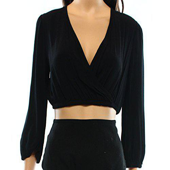

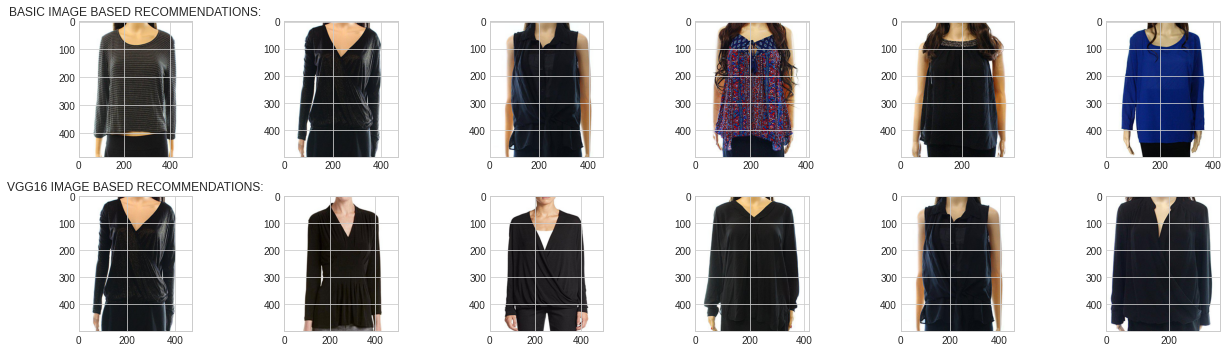

In [ ]:
query_idx = 227
df = df_imgs
listO_imgs_image = fn_similar_vecs(query_idx, df, dim_reduced_img_matrix)
listO_imgs_vgg16 = fn_similar_vecs(query_idx, df, vgg16_vecs)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_image, listO_imgs_vgg16, figsize)


QUERY:


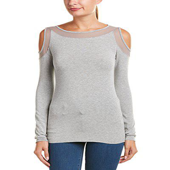

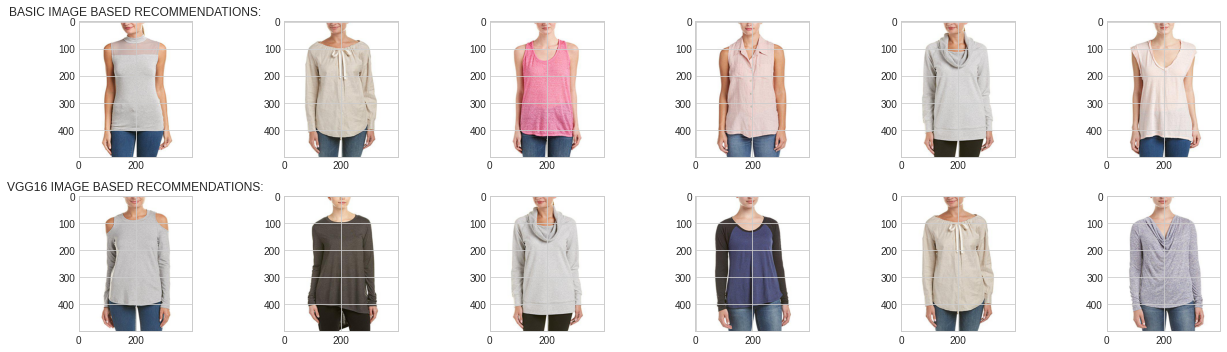

In [ ]:
query_idx = 54
df = df_imgs
listO_imgs_image = fn_similar_vecs(query_idx, df, dim_reduced_img_matrix)
listO_imgs_vgg16 = fn_similar_vecs(query_idx, df, vgg16_vecs)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_image, listO_imgs_vgg16, figsize)


QUERY:


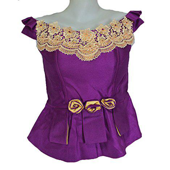

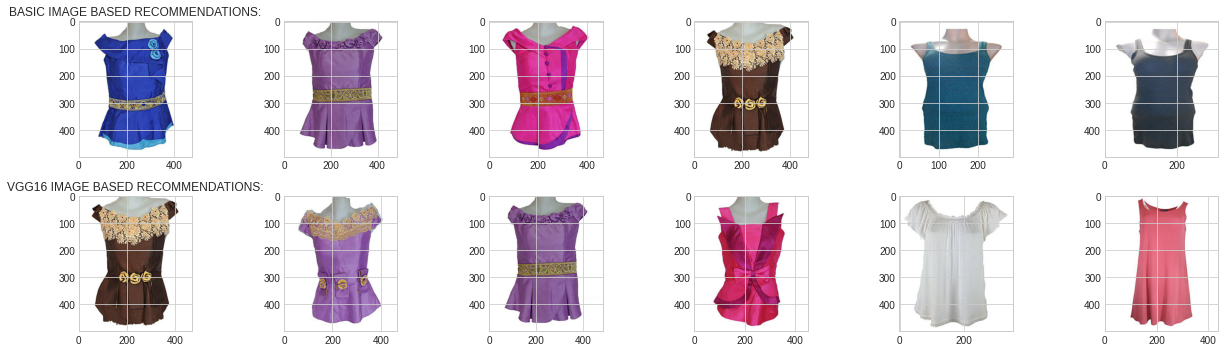

In [ ]:
query_idx = 28
df = df_imgs
listO_imgs_image = fn_similar_vecs(query_idx, df, dim_reduced_img_matrix)
listO_imgs_vgg16 = fn_similar_vecs(query_idx, df, vgg16_vecs)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_image, listO_imgs_vgg16, figsize)


QUERY:


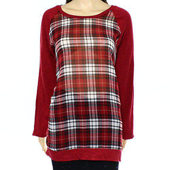

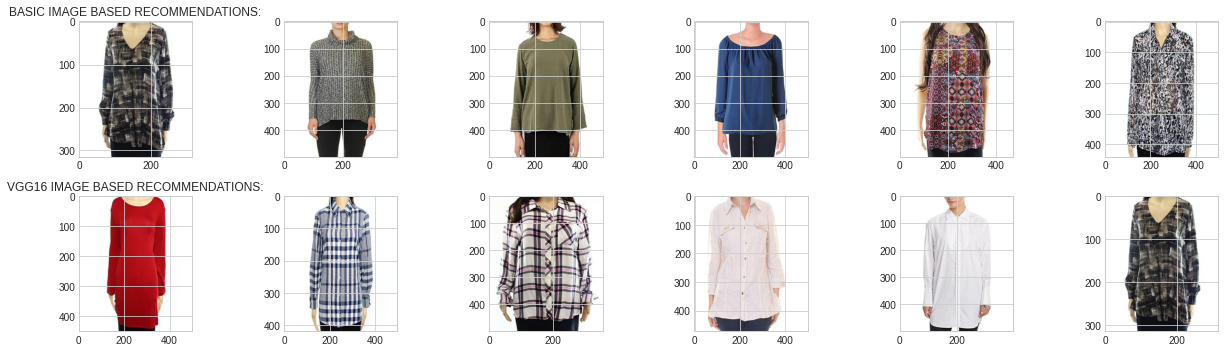

In [ ]:
query_idx = 557
df = df_imgs
listO_imgs_image = fn_similar_vecs(query_idx, df, dim_reduced_img_matrix)
listO_imgs_vgg16 = fn_similar_vecs(query_idx, df, vgg16_vecs)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_image, listO_imgs_vgg16, figsize)


QUERY:


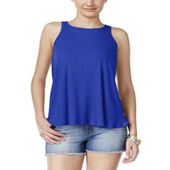

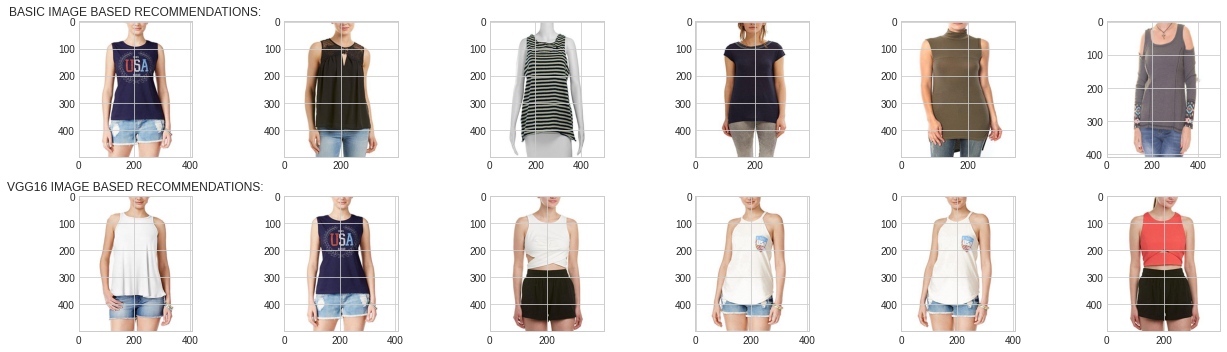

In [ ]:
query_idx = 477
df = df_imgs
listO_imgs_image = fn_similar_vecs(query_idx, df, dim_reduced_img_matrix)
listO_imgs_vgg16 = fn_similar_vecs(query_idx, df, vgg16_vecs)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_image, listO_imgs_vgg16, figsize)


QUERY:


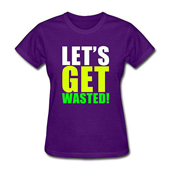

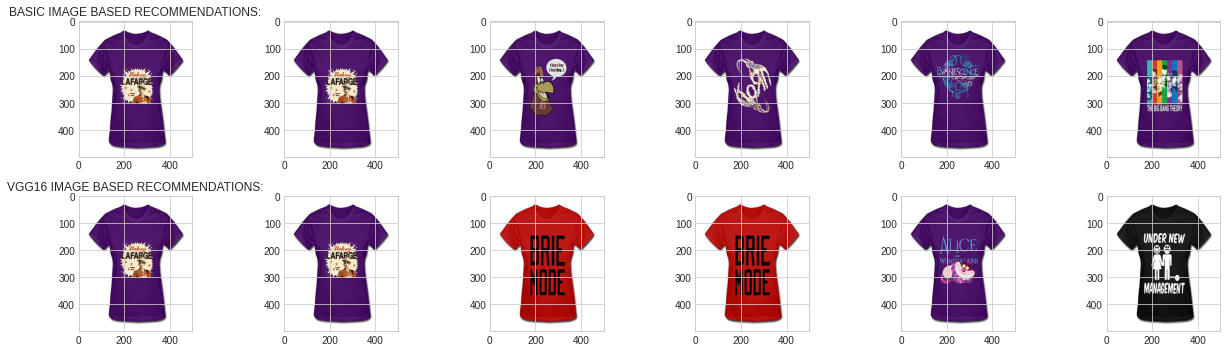

In [ ]:
query_idx = 10222
df = df_imgs
listO_imgs_image = fn_similar_vecs(query_idx, df, dim_reduced_img_matrix)
listO_imgs_vgg16 = fn_similar_vecs(query_idx, df, vgg16_vecs)
figsize = (17, 5)
fn_show_imgs(query_idx, listO_imgs_image, listO_imgs_vgg16, figsize)